In [1]:
import pickle;
import numpy as np;
from numpy.linalg import pinv;
from numpy.polynomial.legendre import legvander;
import tensorflow as tf

import control

In [2]:
import matplotlib
import matplotlib.pyplot as plt;
matplotlib.rcParams.update({'font.size':2}) # default font size on (legible) figures
colors =[[ 0.68627453,  0.12156863,  0.16470589],
       [ 0.96862745,  0.84705883,  0.40000001],
       [ 0.83137256,  0.53333336,  0.6156863 ],
       [ 0.03529412,  0.01960784,  0.14509805],
       [ 0.90980393,  0.59607846,  0.78039217],
       [ 0.69803923,  0.87843138,  0.72941178],
       [ 0.20784314,  0.81568629,  0.89411765]];

colors = np.asarray(colors); # defines a color palette 


In [3]:
def load_pickle_data(file_path,has_control):
        '''load pickle data file for deep Koopman dynamic mode decomposition. 
        Args: 
           file_path: 

        '''     
        file_obj = file(file_path,'rb');
        output_vec = pickle.load(file_obj);

        Yp = output_vec[0]; # list of baseline observables, len(Yp) = (n_samps-1) 
        Yf = output_vec[1]; # list of baseline observables, len(Yf) = (n_samps-1) 

        print("DEBUG:") + repr(len(output_vec));
        if has_control:
          u_control_all_training = output_vec[2];
          #print u_control_all_training[0:10]
        else:
          u_control_all_training = None;
          
        if len(Yp)<2:
            print("Warning: the time-series data provided has no more than 2 points.")
    
        Y_whole = [None]*(len(Yp)+1);
        
        for i in range(0,len(Yp)+1):
            if i == len(Yp):
                Y_whole[i] = Yf[i-1];
            else:
                Y_whole[i] = Yp[i];

        Y_whole = np.asarray(Y_whole);
        
        return np.asarray(Yp),np.asarray(Yf),Y_whole,u_control_all_training;

In [4]:
with_control = 0;

sess = tf.InteractiveSession();

saver = tf.train.import_meta_graph('glycol.pickle.ckpt.meta')
saver.restore(sess,tf.train.latest_checkpoint('./'));

psiyp = tf.get_collection('psiyp')[0];
psiyf = tf.get_collection('psiyf')[0];
forward_prediction = tf.get_collection('forward_prediction')[0];
yp_feed = tf.get_collection('yp_feed')[0];
yf_feed = tf.get_collection('yf_feed')[0];

#psiu = tf.get_collection('psiu')[0];
#u_control = tf.get_collection('u_control')[0];

Kx = tf.get_collection('Kx')[0];
#Ku = tf.get_collection('Ku')[0];

Kx_num = sess.run(Kx);
#Ku_num = sess.run(Ku);
A = np.transpose(Kx_num); # Kx_num and Ku_num were defined using row multi. 



Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./glycol.pickle.ckpt


ControlSlycot: can't find slycot module 'sb03md'

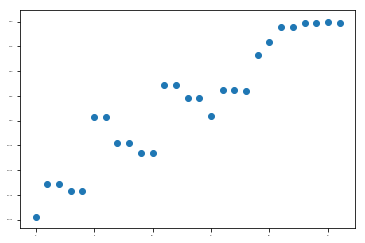

In [21]:
[v,d] = np.linalg.eig(Kx_num)
plt.scatter(np.arange(0,len(v)), v)
import control
B  = np.eye(27)
sys = control.ss(Kx_num,B,B,0.0*B)
control.dlyap(Kx_num,np.dot(B,B.T))


In [5]:
data_directory = 'koopman_data/'
data_suffix = 'glycol.pickle';
data_file = data_directory + data_suffix;
Yp,Yf,Y_whole,temp_var = load_pickle_data(data_file,0);
with_control = 0;
Y_p_old = Yp

num_trains = 430#len(Yp)*5/10;
train_indices = np.arange(0,num_trains,1);#np.random.randint(0,len(Yp),num_trains)
test_indices = np.arange(num_trains,len(Yp),1);#np.random.randint(0,len(Yp),len(Yp)-num_trains);

num_bas_obs = len(Yp[0]);

DEBUG:2


In [ ]:
# # # - - - n-step Prediction Error Analysis - - - # # # 

  
n_points_pred = len(Y_p_old) - test_indices[0]-1;

init_index = test_indices[0];
Yf_final_test_stack_nn = np.asarray(Y_p_old).T[:,init_index:(init_index+1)+n_points_pred]
Ycurr = np.asarray(Y_p_old).T[:,init_index]
Ycurr = np.transpose(Ycurr);
if with_control:
  Uf_final_test_stack_nn = np.asarray(u_control_all_training).T[:,init_index:(init_index+1)+n_points_pred]

#Reshape for tensorflow, which operates using row multiplication. 
Ycurr = Ycurr.reshape(1,num_bas_obs);
psiyp_Ycurr = psiyp.eval(feed_dict={yp_feed:Ycurr});
psiyf_Ycurr = psiyf.eval(feed_dict={yf_feed:Ycurr});


## Define a growing list of vector valued observables that is the forward prediction of the Yf snapshot matrix, initiated from an initial condition in Yp_final_test.   
Yf_final_test_ep_nn = [];
Yf_final_test_ep_nn.append(psiyp_Ycurr.tolist()[0][0:num_bas_obs]); # append the initial seed state value.

for i in range(0,n_points_pred):
  if with_control:
    if len(U_test[i,:])==1:
      U_temp_mat = np.reshape(Uf_final_test_stack_nn[i,:],(1,1));
      psiyp_Ycurr = sess.run(forward_prediction_control, feed_dict={yp_feed:psiyp_Ycurr[:,0:num_bas_obs],u_control:U_temp_mat});#
    else:
      U_temp_mat = np.reshape(Uf_final_test_stack[i,:],(1,n_inputs_control));
      psiyp_Ycurr = sess.run(forward_prediction_control, feed_dict={yp_feed:psiyp_Ycurr[:,0:num_bas_obs],u_control:U_temp_mat});# 
  else:
    psiyp_Ycurr = sess.run(forward_prediction,feed_dict={yp_feed:psiyp_Ycurr[:,0:num_bas_obs]});

  Yout = psiyp_Ycurr.tolist()[0][0:num_bas_obs];
  Yf_final_test_ep_nn.append(Yout);


Yf_final_test_ep_nn = np.asarray(Yf_final_test_ep_nn);
Yf_final_test_ep_nn = np.transpose(Yf_final_test_ep_nn);

prediction_error = np.linalg.norm(Yf_final_test_stack_nn-Yf_final_test_ep_nn,ord='fro')/np.linalg.norm(Yf_final_test_stack_nn,ord='fro');
print('%s%f' % ('[RESULT] n-step Prediction error: ',prediction_error));

import matplotlib
matplotlib.rcParams.update({'font.size':20})


### Make a Prediction Plot
x_range = np.arange(0,350,1)
#x_range = np.arange(0,Yf_final_test_stack_nn.shape[1],1);
for i in range(0,num_bas_obs):
    plt.plot(x_range,Yf_final_test_ep_nn[i,0:len(x_range)],'--',color=colors[i,:]);
    plt.plot(x_range,Yf_final_test_stack_nn[i,0:len(x_range)],'*',color=colors[i,:]);
axes = plt.gca();
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)

#plt.legend(loc='best');
#plt.xlabel('t');
plt.ylim([0,3.0])
fig = plt.gcf();

target_file = data_suffix.replace('.pickle','')+'final_nstep_prediction.pdf';
plt.savefig(target_file);
plt.show();




ERROR! Session/line number was not unique in database. History logging moved to new session 82
[RESULT] n-step Prediction error: 0.267835
